# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

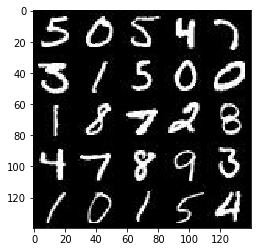

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

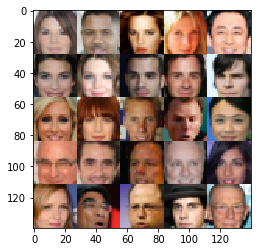

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    # Looks like when it named it learning_rate, it confuses between tensor and value at train process
    # So I decided to name it lr
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Use 4 layer network
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', activation=None)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        # Layer 2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128
        
        # Layer 3
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 7x7x256
        
        # Layer 4
        conv4 = tf.layers.conv2d(conv3, 512, 5, strides=1, padding='SAME', activation=None)
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4,conv4)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(conv4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # 7x7x512
        
        # Layer 2
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=1, padding='SAME', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # 7x7x256
        
        # Layer 3
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='SAME', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        # 14x14x128
        
        # Layer 4
        g4 = tf.layers.conv2d_transpose(g3, 64, 5, strides=2, padding='SAME', activation=None)
        g4 = tf.layers.batch_normalization(g4, training=is_train)
        g4 = tf.maximum(alpha * g4, g4)   
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(g4, out_channel_dim, 3, strides=1, padding='SAME', activation=None)
        # shape = 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr: learning_rate})
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


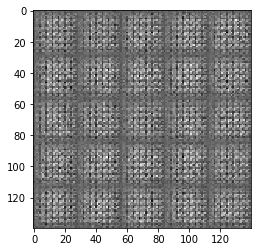

Epoch 1/2... Discriminator Loss: 0.2772... Generator Loss: 2.4067
Epoch 1/2... Discriminator Loss: 0.0282... Generator Loss: 22.9072
Epoch 1/2... Discriminator Loss: 0.1782... Generator Loss: 25.9467
Epoch 1/2... Discriminator Loss: 0.0086... Generator Loss: 6.1120
Epoch 1/2... Discriminator Loss: 0.4084... Generator Loss: 12.2183
Epoch 1/2... Discriminator Loss: 1.9440... Generator Loss: 14.8749
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 3.4861
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 16.8027
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.9197
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 3.2198


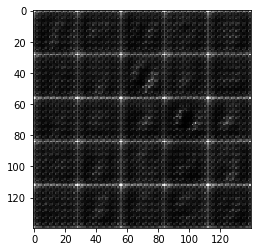

Epoch 1/2... Discriminator Loss: 1.6526... Generator Loss: 3.3692
Epoch 1/2... Discriminator Loss: 1.7568... Generator Loss: 4.9760
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 1.7842
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 2.2940
Epoch 1/2... Discriminator Loss: 2.0224... Generator Loss: 0.2403
Epoch 1/2... Discriminator Loss: 1.7709... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.5616
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.5687


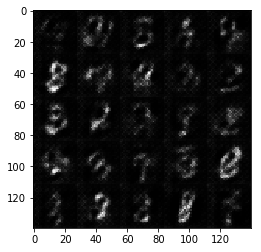

Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.1635
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.7044
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.9381
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 2.0425
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 1.2353
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.9963
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.5358
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.5853


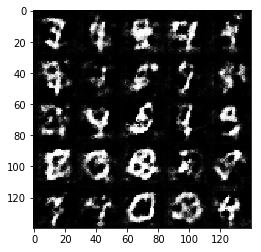

Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.4919
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 1.1766
Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 2.7221
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.4651
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 0.3979


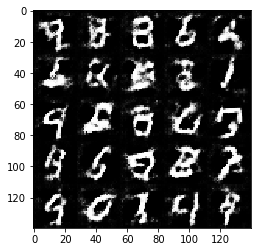

Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.9087
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.6619
Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.2788
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 2.2517
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 0.7511


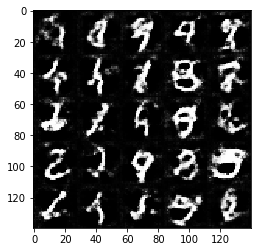

Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 1.9448
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.2782
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 0.9893
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.7503


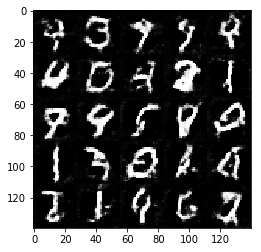

Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.4113
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 1.8369... Generator Loss: 0.2638
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 6.7425... Generator Loss: 6.9697


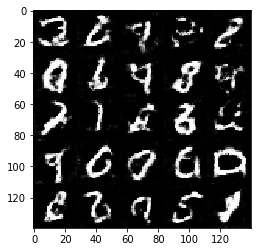

Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 2.6939
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 2.4441
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 2.5153
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 2.2848


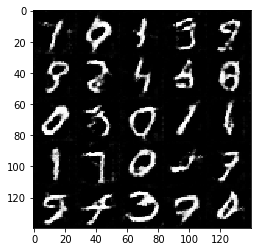

Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.0432
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.1582
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 2.9701
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.4464
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.3977


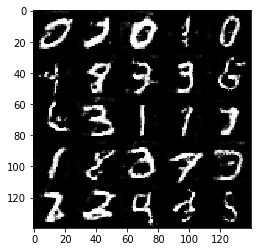

Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.2678


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


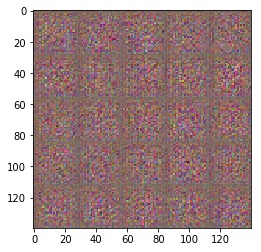

Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 2.1988
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.8736
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 8.7573
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 4.9196
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 0.9946


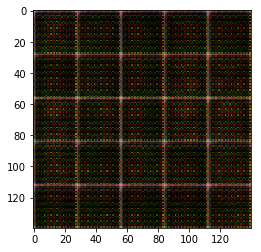

Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 3.6114
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 4.1830
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 2.2435... Generator Loss: 0.2014
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 3.9699
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.7177


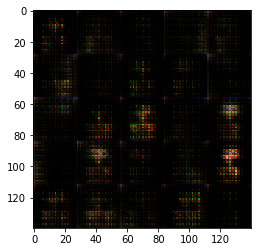

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 3.8416
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 2.0268... Generator Loss: 0.3234
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.3206
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.6273


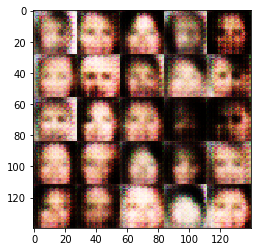

Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.5767


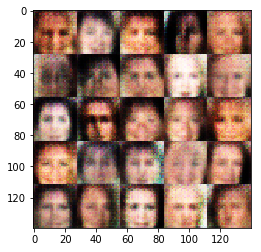

Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 2.4054
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6638


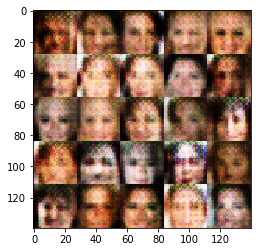

Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 1.3334


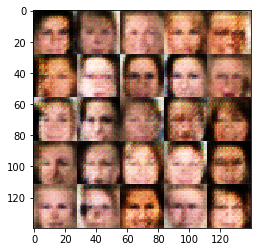

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.6303


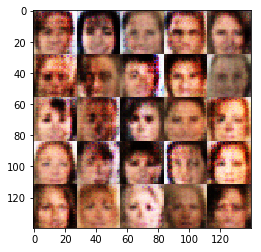

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 1.5950


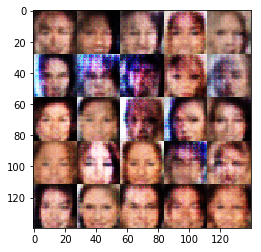

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.1414


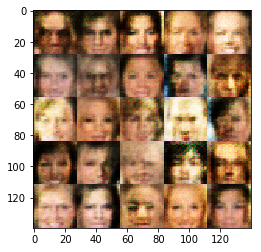

Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.2996


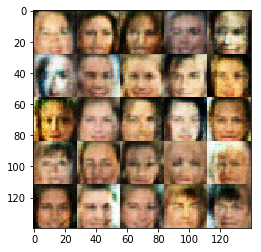

Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.7979
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.7152


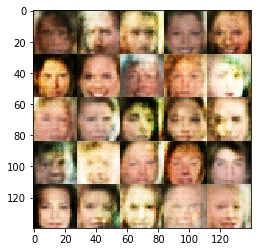

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 1.6910


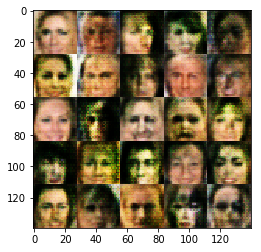

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.7464
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.4171
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.7085


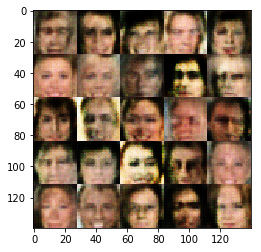

Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.7432
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 2.4624
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.5975


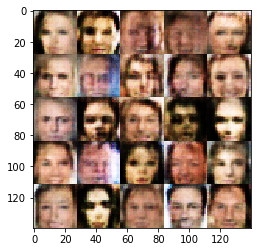

Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 2.6156
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 2.5328... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.5670


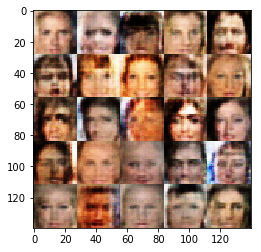

Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 2.7720
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.0817


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.